####Análise de Séries Temporais - Previsão de Preços de Ações

Usar dados históricos de preços de ações para criar uma previsão de tendências futuras, usando a API do Yahoo Finance para coletar os dados.



In [54]:
# importação de bibliotecas
# Manipulação e processamento de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Coleta de dados financeiros
import yfinance as yf

# Modelagem de Séries Temporais
from prophet import Prophet

# Pré-processamento e Modelos de Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Redes Neurais (LSTM) com TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Configuração para evitar mensagens de aviso (opcional)
import warnings
warnings.filterwarnings('ignore')

# Configurações para gráficos (opcional)
plt.style.use('seaborn')
sns.set(style='whitegrid')

In [55]:
# Baixando os dados históricos da ação
ticker = 'AAPL'  # Esta sigla é da empresa Apple Inc.
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

# Visualizar os dados
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2010-01-04 00:00:00+00:00  6.454507  7.643214  7.660714  7.585000  7.622500   
2010-01-05 00:00:00+00:00  6.465664  7.656429  7.699643  7.616071  7.664286   
2010-01-06 00:00:00+00:00  6.362820  7.534643  7.686786  7.526786  7.656429   
2010-01-07 00:00:00+00:00  6.351057  7.520714  7.571429  7.466071  7.562500   
2010-01-08 00:00:00+00:00  6.393281  7.570714  7.571429  7.466429  7.510714   

Price                         Volume  
Ticker                          AAPL  
Date                                  
2010-01-04 00:00:00+00:00  493729600  
2010-01-05 00:00:00+00:00  601904800  
2010-01-06 00:00:00+00:00  552160000  
2010-01-07 00:00:00+00:00  477131200  
2010-01-08 00:00:00+00:00  447610800  


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  3522 non-null   float64
 1   (Close, AAPL)      3522 non-null   float64
 2   (High, AAPL)       3522 non-null   float64
 3   (Low, AAPL)        3522 non-null   float64
 4   (Open, AAPL)       3522 non-null   float64
 5   (Volume, AAPL)     3522 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.6 KB


O que significa cada coluna:

Adj Close (AAPL):

Preço de Fechamento Ajustado. Representa o preço de fechamento da ação ajustado para dividendos, desdobramentos (split) e outros eventos corporativos que podem impactar o valor da ação. É usado em análises históricas para fornecer uma visão precisa dos retornos reais.

Close (AAPL):

Preço de Fechamento. O preço da ação ao final do horário de negociação de um determinado dia. Este é o valor amplamente divulgado na mídia. Não leva em conta ajustes por dividendos ou splits, diferentemente do "Adj Close".

High (AAPL):

Maior Preço do Dia. O maior preço pelo qual a ação foi negociada durante um determinado dia de negociação.

Low (AAPL):

Menor Preço do Dia. O menor preço pelo qual a ação foi negociada durante um determinado dia.

Open (AAPL):

Preço de Abertura. O preço da primeira negociação do dia, quando o mercado abre.

Volume (AAPL):

Volume de Negociação. Indica o número total de ações negociadas durante o dia. Um volume mais alto pode indicar maior interesse ou volatilidade na ação, enquanto um volume baixo pode indicar uma menor atividade no mercado.

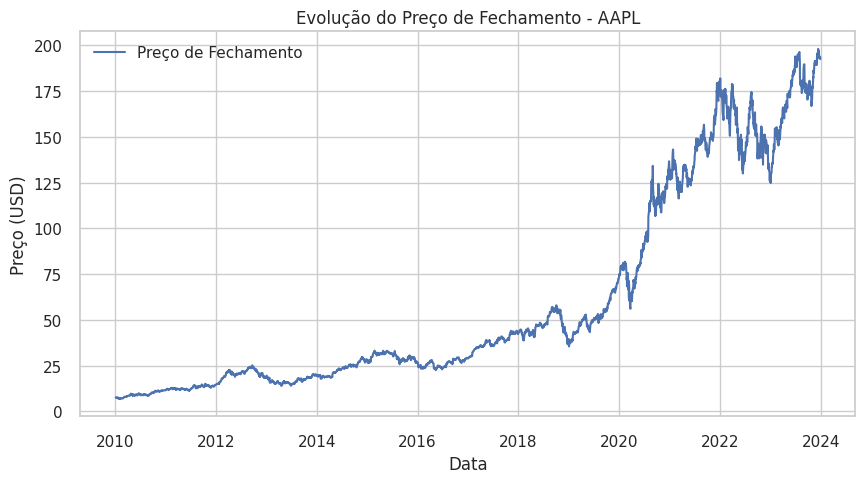

Price     Adj Close        Close         High          Low         Open  \
Ticker         AAPL         AAPL         AAPL         AAPL         AAPL   
count   3522.000000  3522.000000  3522.000000  3522.000000  3522.000000   
mean      57.701397    59.926226    60.528731    59.267621    59.883701   
std       55.642305    55.444533    56.014467    54.812449    55.387520   
min        5.792197     6.858929     7.000000     6.794643     6.870357   
25%       16.986193    19.608571    19.832321    19.402321    19.680447   
50%       29.103411    32.340000    32.633751    32.078751    32.303749   
75%       88.971636    91.207499    92.512501    90.425623    91.213125   
max      197.361084   198.110001   199.619995   197.000000   198.020004   

Price         Volume  
Ticker          AAPL  
count   3.522000e+03  
mean    2.422834e+08  
std     2.204578e+08  
min     2.404830e+07  
25%     9.266760e+07  
50%     1.526602e+08  
75%     3.284715e+08  
max     1.880998e+09  


In [57]:
# Visualizar a série temporal de fechamento
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Preço de Fechamento')
plt.title(f'Evolução do Preço de Fechamento - {ticker}')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# Estatísticas descritivas
print(data.describe())

In [58]:
# Selecionando apenas a coluna de fechamento e escalando os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Função para criar sequências para séries temporais
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Criando dados de treino e teste
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Redimensionando os dados para [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [59]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 5.8958e-04 - val_loss: 0.0013
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 4.6962e-04 - val_loss: 0.0012
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 4.5857e-04 - val_loss: 0.0036
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.8426e-04 - val_loss: 0.0019
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 4.3760e-04 - val_loss: 0.0066
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 7.0489e-04 - val_loss: 0.0025
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 3.7369e-04 - val_loss: 7.8396e-04
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.2041e-04 - val_loss: 0.0011
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 3.8841e-04 - val_loss: 0.0017


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


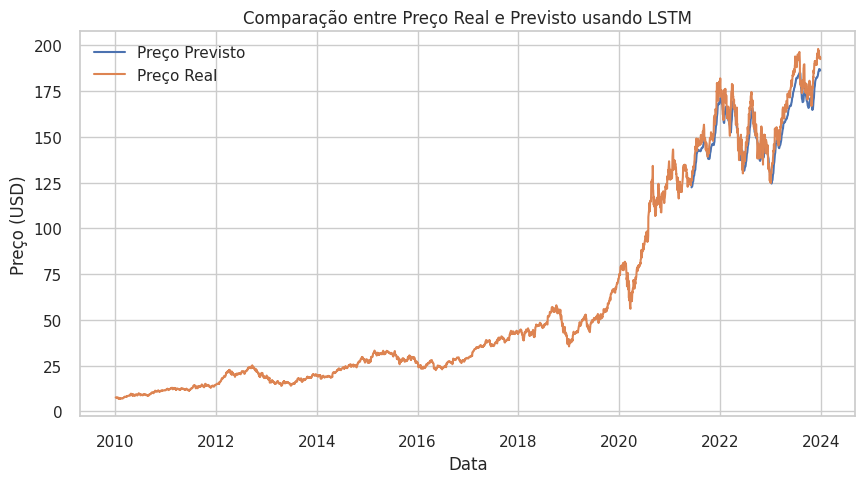

RMSE: 7.868087568858485


In [60]:
# Previsões
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
prediction_dates = data.index[train_size + look_back : len(data) - 1]

plt.figure(figsize=(10, 5))
plt.plot(prediction_dates, predicted_prices, label='Preço Previsto')
plt.plot(data['Close'], label='Preço Real')
plt.title('Comparação entre Preço Real e Previsto usando LSTM')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# Garantindo que os tamanhos dos arrays sejam iguais
real_prices = data['Close'][train_size + look_back:train_size + look_back + len(predicted_prices)]

# Agora, calcular o RMSE corretamente
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f'RMSE: {rmse}')

O LSTM será comparado com o Prophet para verificar qual apresenta melhor desemepnho

In [63]:
# Preparando o DataFrame para o Prophet
df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  # Renomeando para o formato esperado pelo Prophet

# Removendo o fuso horário da coluna 'ds'
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

# Treinando o modelo Prophet
prophet_model = Prophet()
prophet_model.fit(df)

# Fazendo previsões
future = prophet_model.make_future_dataframe(periods=len(X_test))
prophet_forecast = prophet_model.predict(future)

# Visualizando as primeiras previsões
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvmhnt47i/x4lz9wn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvmhnt47i/2qy65hsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72148', 'data', 'file=/tmp/tmpvmhnt47i/x4lz9wn6.json', 'init=/tmp/tmpvmhnt47i/2qy65hsc.json', 'output', 'file=/tmp/tmpvmhnt47i/prophet_modelylonld0s/prophet_model-20241030123129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
4161 2025-09-29  207.054354  185.549299  230.061011
4162 2025-09-30  206.998965  186.485347  229.855713
4163 2025-10-01  207.047354  185.762123  228.934716
4164 2025-10-02  207.024640  185.700772  228.866228
4165 2025-10-03  206.993201  185.264515  228.461317


LSTM: RMSE=7.87, MAE=6.74


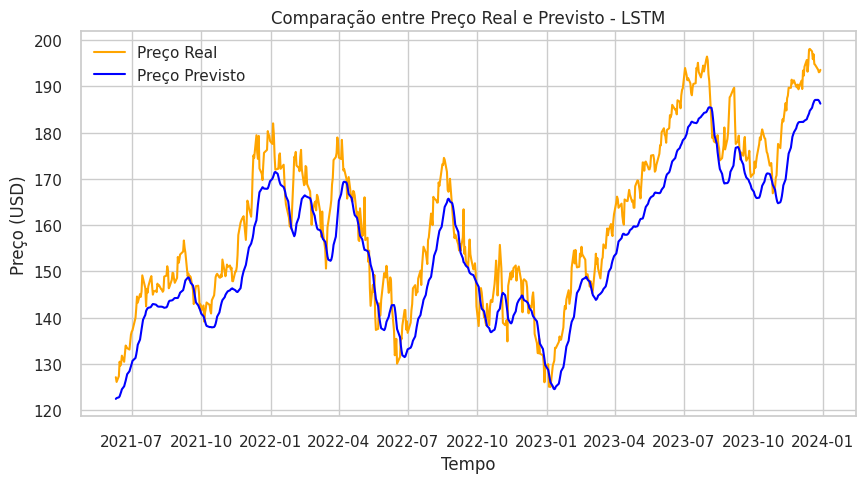

Prophet: RMSE=36.34, MAE=33.16


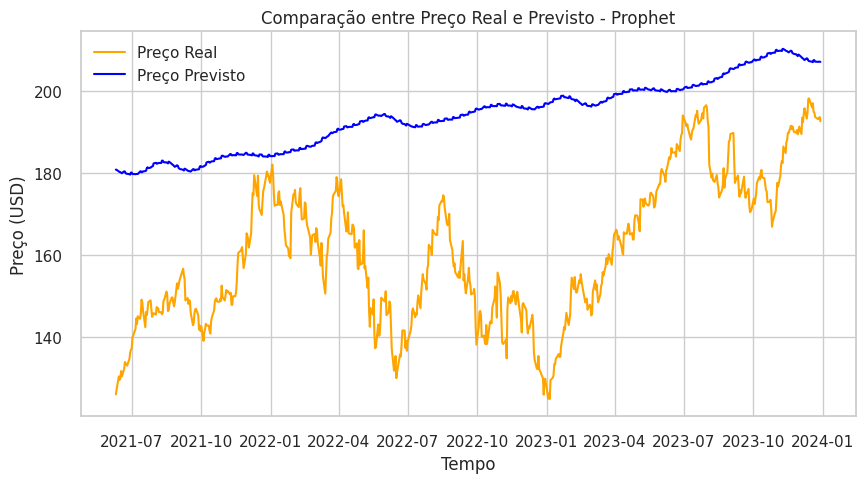

In [64]:


def evaluate_and_plot(real, predicted, model_name, dates=None):
    # Avaliação: RMSE e MAE
    rmse = np.sqrt(mean_squared_error(real, predicted))
    mae = mean_absolute_error(real, predicted)

    # Exibindo as métricas
    print(f'{model_name}: RMSE={rmse:.2f}, MAE={mae:.2f}')

    # Plotando o gráfico comparativo
    plt.figure(figsize=(10, 5))
    if dates is not None:  # Verifica se as datas foram passadas
        plt.plot(dates, real, label='Preço Real', color='orange')
        plt.plot(dates, predicted, label='Preço Previsto', color='blue')
    else:  # Caso contrário, apenas plota os índices
        plt.plot(real, label='Preço Real', color='orange')
        plt.plot(predicted, label='Preço Previsto', color='blue')

    plt.title(f'Comparação entre Preço Real e Previsto - {model_name}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço (USD)')
    plt.legend()
    plt.show()

# 1. Avaliação e Gráfico para LSTM
dates_lstm = data.index[-len(predicted_prices):]  # Pegando as datas corretas
real_prices_lstm = real_prices[-len(predicted_prices):]
evaluate_and_plot(real_prices_lstm, predicted_prices, 'LSTM', dates=dates_lstm)


# 2. Avaliação e Gráfico para Prophet
prophet_yhat = prophet_forecast['yhat'][-len(X_test):]
dates_prophet = data.index[-len(prophet_yhat):]  # Ajustando as datas
real_prophet = data['Close'][-len(prophet_yhat):]
evaluate_and_plot(real_prophet, prophet_yhat, 'Prophet', dates=dates_prophet)


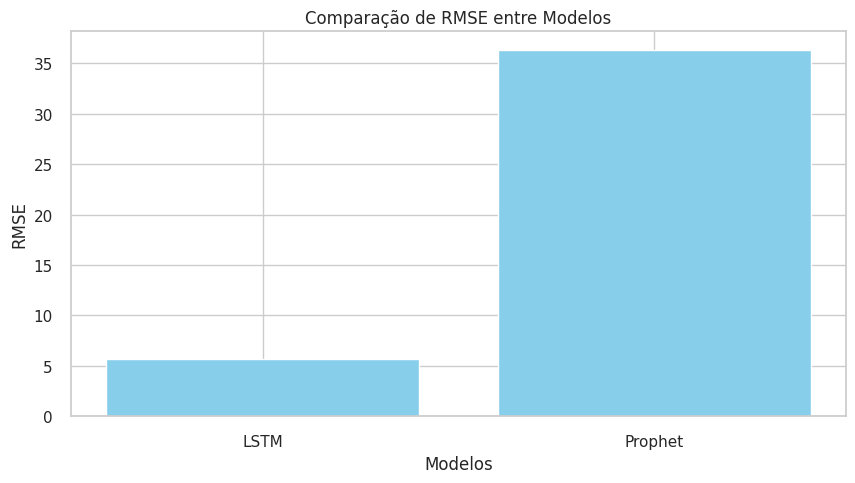

In [65]:
# Dados para o gráfico
models = ['LSTM', 'Prophet']
rmse_values = [rmse_lstm, rmse_prophet]

# Gráfico de barras para comparação de RMSE
plt.figure(figsize=(10, 5))
plt.bar(models, rmse_values, color='skyblue')
plt.title('Comparação de RMSE entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.show()

O gráfico indica que o LSTM apresenta menor RMSE que o Prophet e portanto, entre estas duas alternativas é o que tem melhor desempenho.